references
- [Pyro on PyTorchでベイズ予測分布（MAP推定、変分推論、MCMC） \- HELLO CYBERNETICS](https://www.hellocybernetics.tech/entry/2019/12/08/193220)
- [確率的プログラミング言語 pyro 基本 \- HELLO CYBERNETICS](https://www.hellocybernetics.tech/entry/2019/12/08/033824)

In [1]:
import matplotlib.pyplot
import pyro
import torch
import tqdm

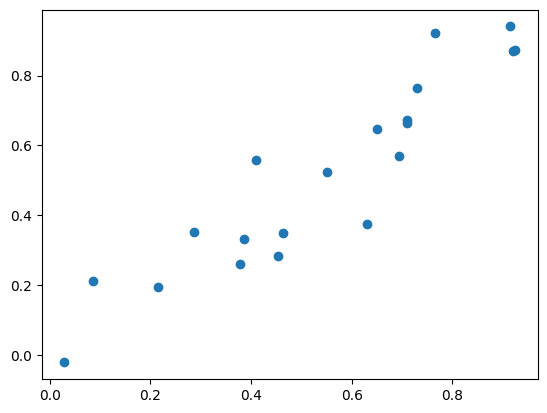

In [2]:
with pyro.plate("plate", size=20):
    x_data = pyro.sample("x_data", pyro.distributions.Uniform(0, 1))
    y_data = pyro.sample("y_data", pyro.distributions.Normal(x_data, 0.1))
_ = matplotlib.pyplot.scatter(x_data, y_data)

In [3]:
def model(x_data, y_data):
    w0 = pyro.sample("w0", pyro.distributions.Normal(0, 1))
    w1 = pyro.sample("w1", pyro.distributions.Normal(0, 1))
    with pyro.plate("plate", x_data.size(0)):
        return pyro.sample(
            "y",
            pyro.distributions.Normal(w0 + w1*x_data, 0.1),
            obs=y_data
        )

torch.Size([100]) torch.Size([100])


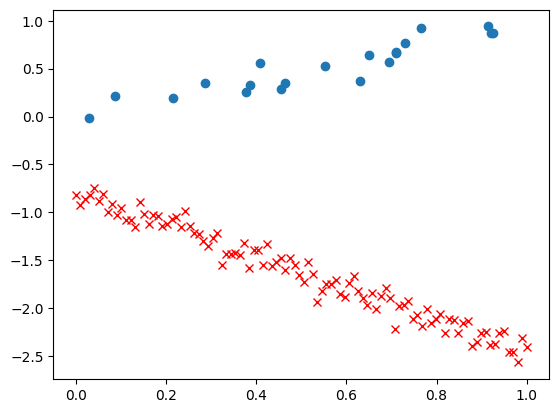

In [4]:
x_index = torch.linspace(0, 1, 100)
with torch.no_grad():
    y_prior = model(x_index, None)

_ = matplotlib.pyplot.plot(x_data, y_data, "o")
print(x_index.shape, y_prior.shape)
_ = matplotlib.pyplot.plot(x_index, y_prior, "rx")

MAP estimation

In [5]:
guide = pyro.infer.autoguide.guides.AutoDelta(model)
optimizer = pyro.optim.Adam(dict(lr=1e-1, betas=(0.95, 0.999)))
svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.JitTrace_ELBO())

100%|██████████| 1000/1000 [00:01<00:00, 957.60it/s]
/tmp/ipykernel_1153095/141899010.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


AutoDelta.w0:	-0.002179593313485384
AutoDelta.w1:	0.9520390629768372


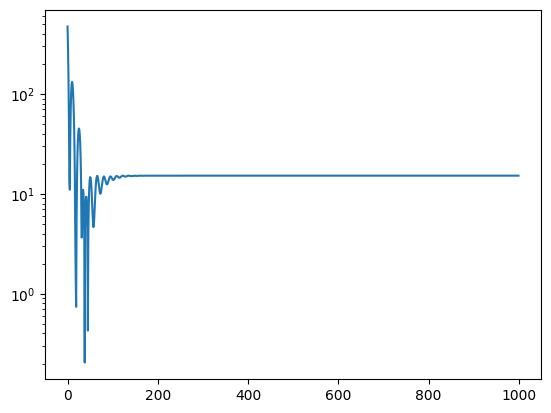

In [6]:
loss_curve = []
for step in tqdm.trange(1000):
    loss = svi.step(x_data, y_data)
    loss_curve.append(abs(loss))
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot()
line, = ax.plot(loss_curve)
ax.set_yscale('log')
fig.show()

for name in pyro.get_param_store():
    print("{}:\t{}".format(name, pyro.param(name)))

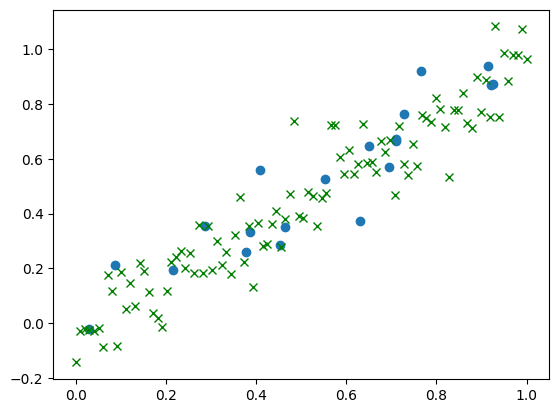

In [7]:
y_hat = pyro.condition(model, data=dict(
    w0 = pyro.param('AutoDelta.w0'),
    w1 = pyro.param('AutoDelta.w1'),
))
with torch.no_grad():
    y_predicted_w = y_hat(x_index, None)

_ = matplotlib.pyplot.plot(x_data, y_data, 'o')
_ = matplotlib.pyplot.plot(x_index, y_predicted_w, 'gx')

In [8]:
pyro.clear_param_store()

Variational Inference

In [9]:
guide = pyro.infer.autoguide.guides.AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam(dict(lr=1e-1, betas=(0.95, 0.999)))
svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.JitTrace_ELBO())

100%|██████████| 1000/1000 [00:01<00:00, 766.56it/s]
/tmp/ipykernel_1153095/141899010.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


AutoDiagonalNormal.loc:	Parameter containing:
tensor([0.0112, 0.9538], requires_grad=True)
AutoDiagonalNormal.scale:	tensor([0.0241, 0.0412], grad_fn=<SoftplusBackward0>)


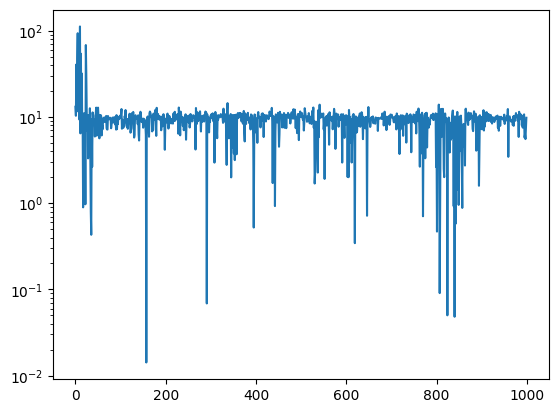

In [10]:
loss_curve = []
for step in tqdm.trange(1000):
    loss = svi.step(x_data, y_data)
    loss_curve.append(abs(loss))
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot()
line, = ax.plot(loss_curve)
ax.set_yscale('log')
fig.show()

for name in pyro.get_param_store():
    print("{}:\t{}".format(name, pyro.param(name)))

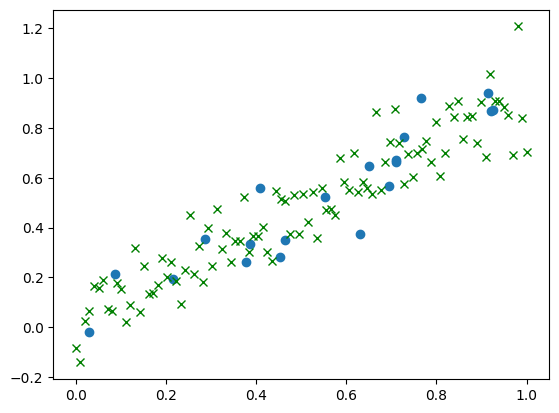

In [11]:
y_hat = pyro.condition(model, data=dict(
    w0 = pyro.param('AutoDiagonalNormal.loc')[0],
    w1 = pyro.param('AutoDiagonalNormal.loc')[1],
))
with torch.no_grad():
    y_predicted_w = y_hat(x_index, None)

_ = matplotlib.pyplot.plot(x_data, y_data, 'o')
_ = matplotlib.pyplot.plot(x_index, y_predicted_w, 'gx')

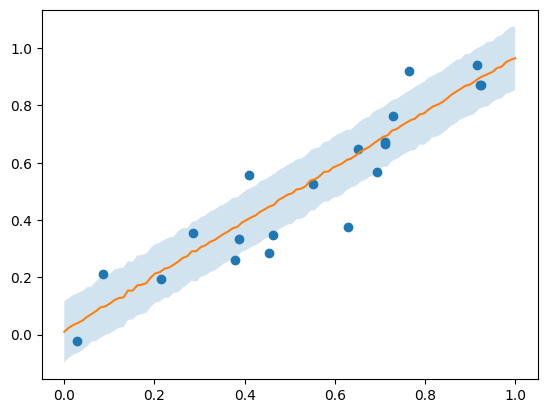

In [12]:
predictive_y = pyro.infer.Predictive(model=model, guide=guide, num_samples=1000, return_sites=['y'])
with torch.no_grad():
    y_sampled = predictive_y.get_samples(x_index, None)

_ = matplotlib.pyplot.plot(x_data, y_data, 'o')
_ = matplotlib.pyplot.plot(x_index, y_sampled['y'].mean(0))
_ = matplotlib.pyplot.fill_between(
    x_index,
    y_sampled['y'].mean(0) - y_sampled['y'].std(0),
    y_sampled['y'].mean(0) + y_sampled['y'].std(0),
    alpha=0.2
)